In [ ]:
from google.cloud import bigquery
from google.colab import auth
import matplotlib.pyplot as plt
import pandas as pd

auth.authenticate_service_account()
client = bigquery.Client()
project_name='weatherlink-404323'




Successfully saved credentials for pipelineauth@weatherlink-404323.iam.gserviceaccount.com


In [ ]:

dataset = 'weatherlink-master'

# Define your SQL query
query = """
SELECT
  a.number_of_fatalities, a.geoid, a.year, a.timestamp_of_crash, a.hour_of_arrival_at_scene, a.minute_of_arrival_at_scene, a.hour_of_crash, a.minute_of_crash, a.hour_of_ems_arrival_at_hospital, a.minute_of_ems_arrival_at_hospital, a.hour_of_notification, a.minute_of_notification,
  c.income_per_capita, c.black_pop, c.total_pop, c.hispanic_pop, c.asian_pop, c.amerindian_pop
FROM
  `weatherlink-404323.weatherlink_master.census_master` c
JOIN
  `weatherlink-404323.weatherlink_master.accident_master` a
ON
  c.YEAR = a.YEAR AND c.geo_id = a.GEOID
"""

# Execute the query and store the results in a Pandas DataFrame
df = client.query(query).to_dataframe()


In [ ]:

print(df)


        number_of_fatalities  geoid  year         timestamp_of_crash  \
0                          1   4015  2015  2015-06-12 00:43:00+00:00   
1                          1  21145  2015  2015-08-14 00:18:00+00:00   
2                          1  23011  2015  2015-11-26 00:53:00+00:00   
3                          1  37021  2015  2015-05-11 00:43:00+00:00   
4                          1  44007  2015  2015-07-26 00:36:00+00:00   
...                      ...    ...   ...                        ...   
122001                     1  12086  2019  2019-05-15 09:13:00+00:00   
122002                     1  49035  2019  2019-09-10 00:00:00+00:00   
122003                     1  12057  2019  2019-03-27 20:30:00+00:00   
122004                     1   4001  2019  2019-03-09 15:23:00+00:00   
122005                     1   4013  2019  2019-10-13 15:00:00+00:00   

        hour_of_arrival_at_scene  minute_of_arrival_at_scene  hour_of_crash  \
0                              1                        

In [ ]:
# Count the number of rows with null values in time-related columns
num_nulls = df[['hour_of_notification', 'minute_of_notification', 'hour_of_crash', 'minute_of_crash', 'hour_of_arrival_at_scene', 'minute_of_arrival_at_scene', 'hour_of_ems_arrival_at_hospital', 'minute_of_ems_arrival_at_hospital']].isnull().any(axis=1).sum()

print(f"Number of Rows with Null Values: {num_nulls}")

Number of Rows with Null Values: 0


In [ ]:

# Create a function to convert hour and minute to total minutes
def time_to_minutes(hour, minute):
    return hour * 60 + minute

# Calculate how long until the notification came in
df['NotificationResponseTime'] = df.apply(lambda row: (time_to_minutes(row['hour_of_notification'], row['minute_of_notification']) - time_to_minutes(row['hour_of_crash'], row['minute_of_crash'])) % (24 * 60), axis=1)

# Calculate response time for emergency services (from when the crash happened to when they arrived at the scene)
df['EmsResponseTime'] = df.apply(lambda row: (time_to_minutes(row['hour_of_arrival_at_scene'], row['minute_of_arrival_at_scene']) - time_to_minutes(row['hour_of_crash'], row['minute_of_crash'])) % (24 * 60), axis=1)

# Calculate delivery time for emergency services (when they get to the hospital from when they arrived at the scene)
df['EmsDeliveryTime'] = df.apply(lambda row: (time_to_minutes(row['hour_of_ems_arrival_at_hospital'], row['minute_of_ems_arrival_at_hospital']) - time_to_minutes(row['hour_of_arrival_at_scene'], row['minute_of_arrival_at_scene'])) % (24 * 60), axis=1)

# Calculate total response time from when the crash happened to when they made it to the hospital
df['TotalResponseTime'] = df.apply(lambda row: (time_to_minutes(row['hour_of_ems_arrival_at_hospital'], row['minute_of_ems_arrival_at_hospital']) - time_to_minutes(row['hour_of_crash'], row['minute_of_crash'])) % (24 * 60), axis=1)

# Print a few rows to verify the calculations
print("Sample Rows:")
print(df[['NotificationResponseTime','EmsResponseTime','EmsDeliveryTime', 'TotalResponseTime']].head())


# Print averages
average_notification_response_time = df['NotificationResponseTime'].mean()
average_ems_response_time = df['EmsResponseTime'].mean()
average_ems_delivery_time = df['EmsDeliveryTime'].mean()
average_total_response_time = df['TotalResponseTime'].mean()

print("\nAverages:")
print(f"Notification Response Time: {average_notification_response_time:.2f} minutes")
print(f"EMS Response Time: {average_ems_response_time:.2f} minutes")
print(f"EMS Delivery Time: {average_ems_delivery_time:.2f} minutes")
print(f"Total Response Time: {average_total_response_time:.2f} minutes")


Sample Rows:
   NotificationResponseTime  EmsResponseTime  EmsDeliveryTime  \
0                         4               17              133   
1                         2                8               16   
2                      1432             1432               50   
3                         0                6               18   
4                         1                6                6   

   TotalResponseTime  
0                150  
1                 24  
2                 42  
3                 24  
4                 12  

Averages:
Notification Response Time: 465.15 minutes
EMS Response Time: 398.20 minutes
EMS Delivery Time: 298.65 minutes
Total Response Time: 569.26 minutes


In [ ]:
(time_to_minutes(0, 22) - time_to_minutes(23, 17)) % (24 * 60)

65

In [ ]:
project_id = 'weatherlink-404323'
dataset_id = 'weatherlink_master'
table_id = 'accident_response_times'
table_ref = f'{project_id}.{dataset_id}.{table_id}'


In [ ]:
# Calculate average response times for each county (GEOID)
average_response_times = df.groupby('geoid').agg({
    'TotalResponseTime': 'mean',
    'EmsResponseTime': 'mean',
    'EmsDeliveryTime': 'mean',
    'NotificationResponseTime': 'mean',
    # Add other columns as needed
}).reset_index()

In [ ]:
average_response_times

,geoid,TotalResponseTime,EmsResponseTime,EmsDeliveryTime,NotificationResponseTime
0,1003,670.807453,129.571429,621.732919,350.192547
1,1015,592.980000,88.020000,548.160000,270.220000
2,1043,572.055046,110.844037,527.266055,438.155963
3,1049,544.628205,79.294872,502.256410,319.307692
4,1051,664.050000,34.033333,654.016667,448.233333
...,...,...,...,...,...
826,55133,456.188119,262.574257,307.673267,134.465347
827,55139,665.777778,322.644444,407.133333,232.466667
828,55141,617.282051,219.410256,397.871795,147.666667
829,56021,385.966102,50.745763,335.220339,38.779661


In [ ]:
from io import StringIO
from pandas_gbq import to_gbq
from pandas_gbq.schema import generate_bq_schema

# Define the schema for the new table
schema = [
    bigquery.SchemaField('geoid', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('TotalResponseTime', 'FLOAT', mode='REQUIRED'),
    bigquery.SchemaField('EmsResponseTime', 'FLOAT', mode='REQUIRED'),
    bigquery.SchemaField('EmsDeliveryTime', 'FLOAT', mode='REQUIRED'),
    bigquery.SchemaField('NotificationResponseTime', 'FLOAT', mode='REQUIRED'),
    # Add other columns as needed
]

# This is a weird work around to get the dataframe acceptable for upload
# temporarily store the dataframe as a csv in a string variable
temp_csv_string = average_response_times.to_csv(sep=";", index=False)
temp_csv_string_IO = StringIO(temp_csv_string)
# create new dataframe from string variable
new_df = pd.read_csv(temp_csv_string_IO, sep=";")

to_gbq(new_df, f"{dataset_id}.{table_id}", project_id=project_id, if_exists='replace')

print(f"New table created: {table_ref}")

100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]

New table created: weatherlink-404323.weatherlink_master.accident_response_times


It looks lke some of those are erronously large, so we need to clean the data

In [ ]:
# Count the number of rows with null values in time-related columns
num_nulls = df[['hour_of_notification', 'minute_of_notification', 'hour_of_crash', 'minute_of_crash', 'hour_of_arrival_at_scene', 'minute_of_arrival_at_scene', 'hour_of_ems_arrival_at_hospital', 'minute_of_ems_arrival_at_hospital']].isnull().any(axis=1).sum()

print(f"Number of Rows with Null Values: {num_nulls}")

Number of Rows with Null Values: 0


Wow it looks like there are no null values. So lets remove any huge outliers

In [ ]:
# Count NaN values for each column
nan_counts = df[['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']].isna().sum()

print("NaN Counts:")
print(nan_counts)

# Count NaN values for each column
nan_counts = df[['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']].isnull().sum()

print("Null Counts:")
print(nan_counts)

NaN Counts:
NotificationResponseTime    0
EmsResponseTime             0
EmsDeliveryTime             0
TotalResponseTime           0
dtype: int64
Null Counts:
NotificationResponseTime    0
EmsResponseTime             0
EmsDeliveryTime             0
TotalResponseTime           0
dtype: int64


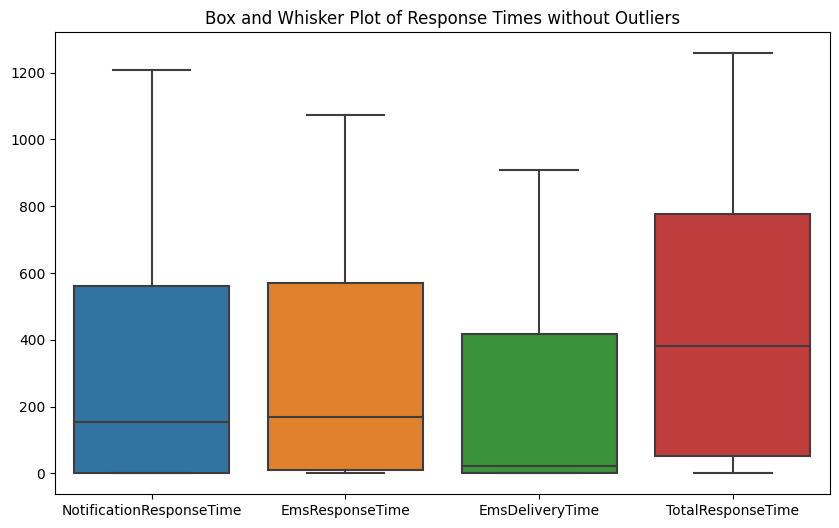

Using a z score of 1.5 you filtered out 32576 values 

Averages (UnCleaned Data):
Notification Response Time: 465.15 minutes
EMS Response Time: 398.20 minutes
EMS Delivery Time: 298.65 minutes
Total Response Time: 569.26 minutes

Averages (Cleaned Data):
Notification Response Time: 299.08 minutes
EMS Response Time: 307.20 minutes
EMS Delivery Time: 204.60 minutes
Total Response Time: 440.25 minutes


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert relevant columns to numeric
df[['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']] = df[['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']].apply(pd.to_numeric, errors='coerce')

# Calculate z-scores for all rows
z_scores_all = stats.zscore(df[['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']], nan_policy='omit')

# Set a z-score threshold for outliers (e.g., 2 standard deviations)
z_threshold = 2

# Create mask for outliers
outliers_mask = (z_scores_all >= z_threshold) | (z_scores_all <= -z_threshold)

# Apply any() along the columns to create a 1D mask
any_outliers_mask = outliers_mask.any(axis=1)

# Filter the DataFrame based on the outliers mask
df_filtered = df.loc[~any_outliers_mask]

# Explicitly select the columns of interest after filtering
columns_of_interest = ['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']

# Create a box and whisker plot with the filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered[columns_of_interest])
plt.title('Box and Whisker Plot of Response Times without Outliers')
plt.show()

# Calculate the number of rows filtered out
num_filtered = df.shape[0] - df.loc[~any_outliers_mask].shape[0]

# Summary stats about the cleaning process
print(f"Using a z score of {z_threshold} you filtered out {num_filtered} values ")

# Recalculate averages for the cleaned data
average_notification_response_time_cleaned = df['NotificationResponseTime'].mean()
average_ems_response_time_cleaned = df['EmsResponseTime'].mean()
average_ems_delivery_time_cleaned = df['EmsDeliveryTime'].mean()
average_total_response_time_cleaned = df['TotalResponseTime'].mean()

print("\nAverages (UnCleaned Data):")
print(f"Notification Response Time: {average_notification_response_time_cleaned:.2f} minutes")
print(f"EMS Response Time: {average_ems_response_time_cleaned:.2f} minutes")
print(f"EMS Delivery Time: {average_ems_delivery_time_cleaned:.2f} minutes")
print(f"Total Response Time: {average_total_response_time_cleaned:.2f} minutes")

average_notification_response_time_cleaned = df_filtered['NotificationResponseTime'].mean()
average_ems_response_time_cleaned = df_filtered['EmsResponseTime'].mean()
average_ems_delivery_time_cleaned = df_filtered['EmsDeliveryTime'].mean()
average_total_response_time_cleaned = df_filtered['TotalResponseTime'].mean()

print("\nAverages (Cleaned Data):")
print(f"Notification Response Time: {average_notification_response_time_cleaned:.2f} minutes")
print(f"EMS Response Time: {average_ems_response_time_cleaned:.2f} minutes")
print(f"EMS Delivery Time: {average_ems_delivery_time_cleaned:.2f} minutes")
print(f"Total Response Time: {average_total_response_time_cleaned:.2f} minutes")


In [ ]:

# Create new columns for percentage calculations
df_filtered['BlackPercentage'] = (df_filtered['black_pop'] / df_filtered['total_pop']) * 100
df_filtered['HispanicPercentage'] = (df_filtered['hispanic_pop'] / df_filtered['total_pop']) * 100
df_filtered['AsianPercentage'] = (df_filtered['asian_pop'] / df_filtered['total_pop']) * 100
df_filtered['AmerindianPercentage'] = (df_filtered['amerindian_pop'] / df_filtered['total_pop']) * 100

# If needed, you can drop the intermediate columns used for calculation
# df = df.drop(['black_pop', 'hispanic_pop', 'asian_pop', 'amerindian_pop'], axis=1)


<ipython-input-83-104f4fed2c84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BlackPercentage'] = (df_filtered['black_pop'] / df_filtered['total_pop']) * 100
<ipython-input-83-104f4fed2c84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['HispanicPercentage'] = (df_filtered['hispanic_pop'] / df_filtered['total_pop']) * 100
<ipython-input-83-104f4fed2c84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [ ]:
# Print a few rows
print("Sample Rows:")
print(df_filtered[['BlackPercentage', 'HispanicPercentage', 'AsianPercentage', 'AmerindianPercentage']].head())

# Calculate and print the average
average_percentages = df_filtered[['BlackPercentage', 'HispanicPercentage', 'AsianPercentage', 'AmerindianPercentage']].mean()
print("\nAverage Percentages:")
print(average_percentages)

Sample Rows:
   BlackPercentage  HispanicPercentage  AsianPercentage  AmerindianPercentage
0         1.083829           16.172455         1.210822              2.657067
1              NaN                 NaN              NaN                   NaN
3              NaN                 NaN              NaN                   NaN
4         7.858267           21.294515         4.112251              0.350923
6        29.334279           55.118644         3.609689              0.204130

Average Percentages:
BlackPercentage         13.900822
HispanicPercentage      23.627632
AsianPercentage          6.019564
AmerindianPercentage     0.734391
dtype: float64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


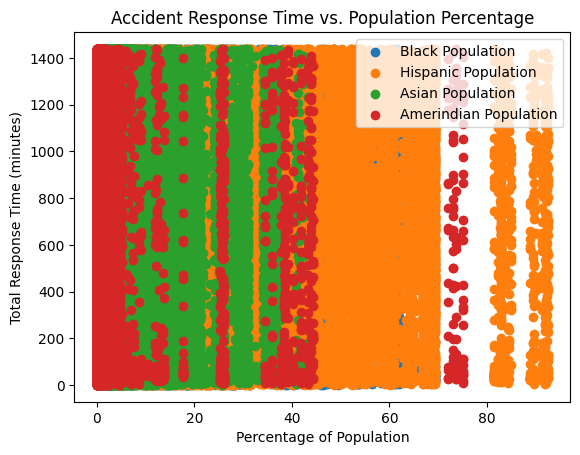

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with the relevant columns
# ...

# Scatterplot for Black Population
plt.scatter(df['BlackPercentage'], df['TotalResponseTime'], label='Black Population')

# Scatterplot for Hispanic Population
plt.scatter(df['HispanicPercentage'], df['TotalResponseTime'], label='Hispanic Population')

# Scatterplot for Asian Population
plt.scatter(df['AsianPercentage'], df['TotalResponseTime'], label='Asian Population')

# Scatterplot for Amerindian Population
plt.scatter(df['AmerindianPercentage'], df['TotalResponseTime'], label='Amerindian Population')

# Add labels and legend
plt.xlabel('Percentage of Population')
plt.ylabel('Total Response Time (minutes)')
plt.title('Accident Response Time vs. Population Percentage')
plt.legend()
plt.show()

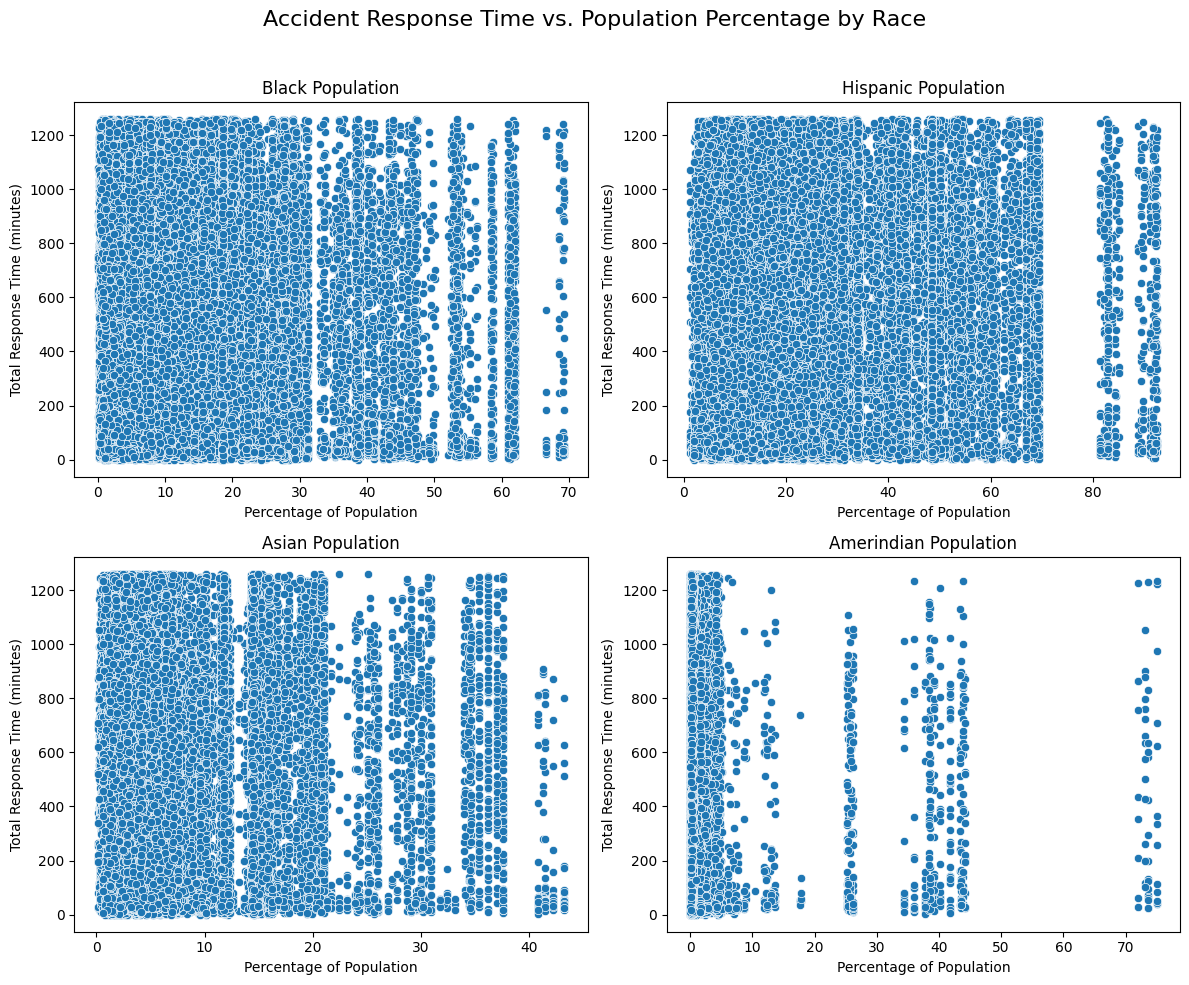

In [ ]:
# Assuming you have a DataFrame named 'df_filtered' with the relevant columns

# Define the races to plot
races = ['Black', 'Hispanic', 'Asian', 'Amerindian']

# Create a grid layout for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Accident Response Time vs. Population Percentage by Race', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot each race on a separate subplot
for i, race in enumerate(races):
    sns.scatterplot(data=df_filtered, x=f'{race}Percentage', y='TotalResponseTime', ax=axes[i])
    axes[i].set_title(f'{race} Population')

# Set common labels
for ax in axes:
    ax.set_xlabel('Percentage of Population')
    ax.set_ylabel('Total Response Time (minutes)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the title
plt.show()

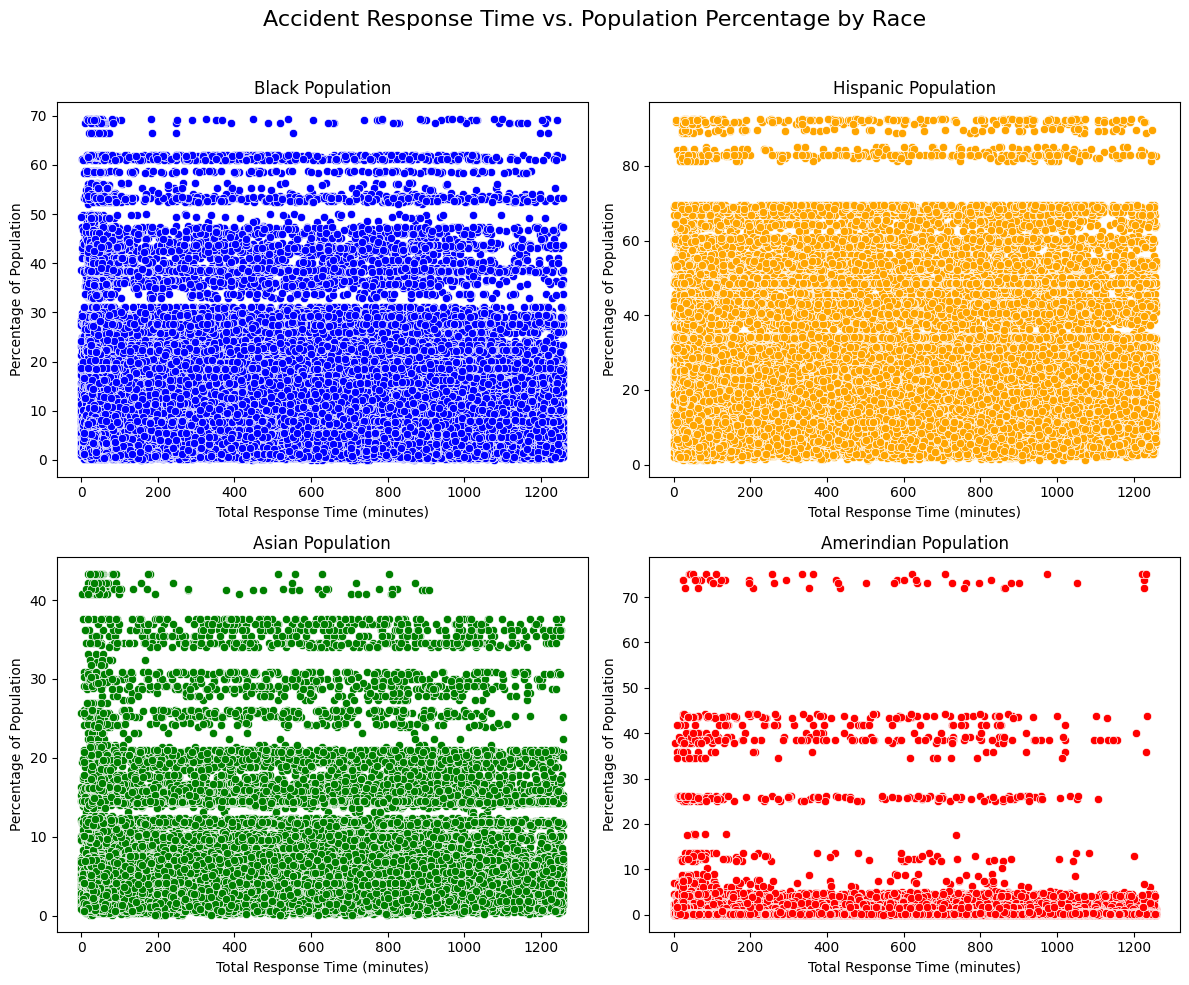

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_filtered' with the relevant columns

# Define the races to plot
races = ['Black', 'Hispanic', 'Asian', 'Amerindian']

# Create a grid layout for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Accident Response Time vs. Population Percentage by Race', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Define colors for each race
colors = ['blue', 'orange', 'green', 'red']

# Plot each race on a separate subplot with flipped axes and different colors
for i, (race, color) in enumerate(zip(races, colors)):
    sns.scatterplot(data=df_filtered, x='TotalResponseTime', y=f'{race}Percentage', ax=axes[i], color=color)
    axes[i].set_title(f'{race} Population')

# Set common labels
for ax in axes:
    ax.set_xlabel('Total Response Time (minutes)')
    ax.set_ylabel('Percentage of Population')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the title
plt.show()


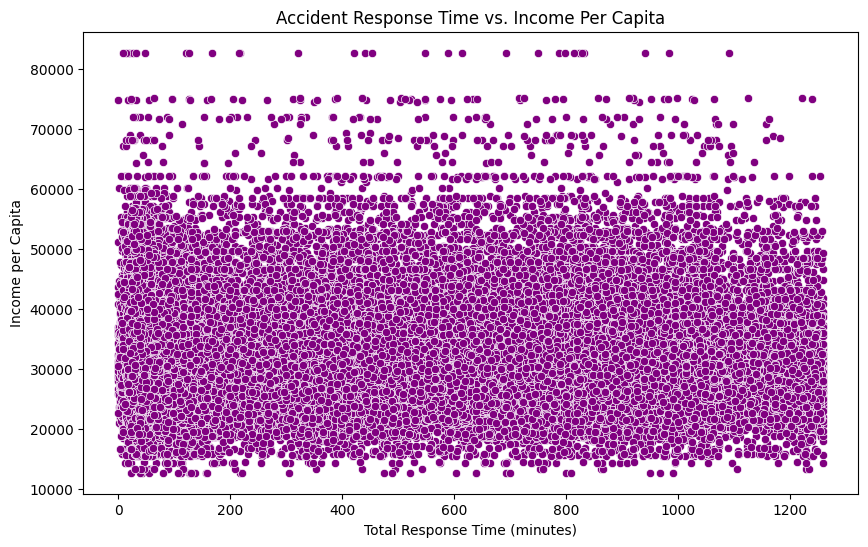

In [ ]:
# Assuming you have a DataFrame named 'df_filtered' with the relevant columns

# Create a scatter plot for 'income_per_capita' against 'TotalResponseTime'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='TotalResponseTime', y='income_per_capita', color='purple')
plt.title('Accident Response Time vs. Income Per Capita')
plt.xlabel('Total Response Time (minutes)')
plt.ylabel('Income per Capita')
plt.show()

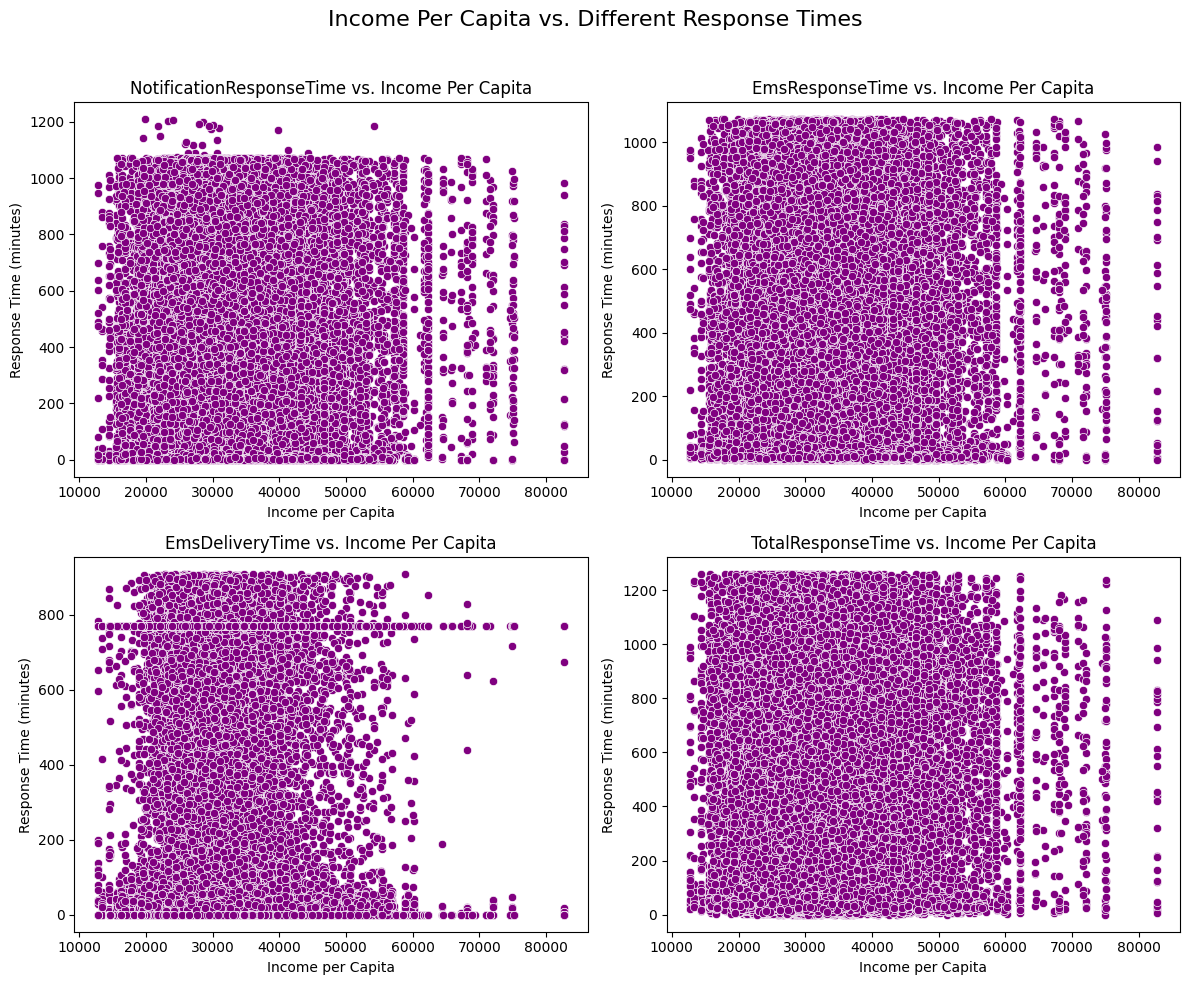

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_filtered' with the relevant columns

# Create a grid layout for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Income Per Capita vs. Different Response Times', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Define response time columns
response_time_columns = ['NotificationResponseTime', 'EmsResponseTime', 'EmsDeliveryTime', 'TotalResponseTime']

# Plot each response time on a separate subplot
for i, response_time in enumerate(response_time_columns):
    sns.scatterplot(data=df_filtered, x='income_per_capita', y=response_time, ax=axes[i], color='purple')
    axes[i].set_title(f'{response_time} vs. Income Per Capita')

# Set common labels
for ax in axes:
    ax.set_xlabel('Income per Capita')
    ax.set_ylabel('Response Time (minutes)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the title
plt.show()


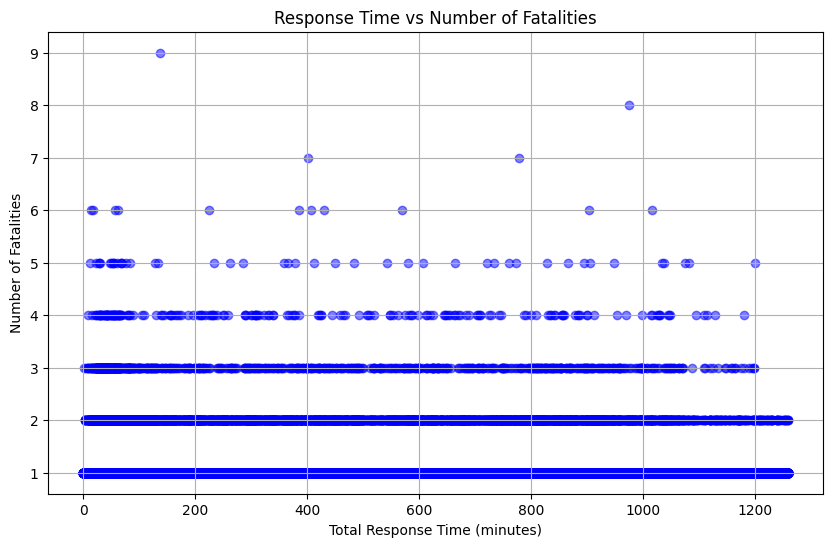

In [ ]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['TotalResponseTime'], df_filtered['number_of_fatalities'], color='blue', alpha=0.5)
plt.title('Response Time vs Number of Fatalities')
plt.xlabel('Total Response Time (minutes)')
plt.ylabel('Number of Fatalities')
plt.grid(True)
plt.show()

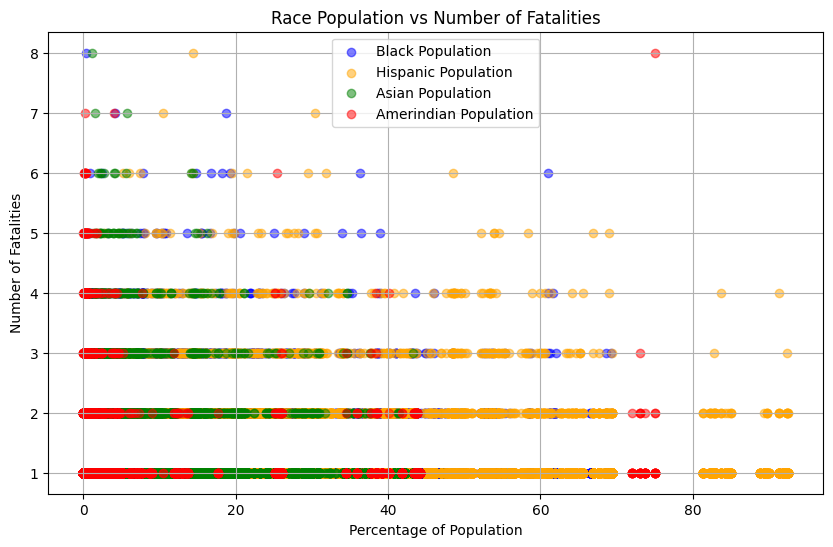

In [ ]:
# Create a scatter plot for Black Population vs Number of Fatalities
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['BlackPercentage'], df_filtered['number_of_fatalities'], label='Black Population', color='blue', alpha=0.5)

# Create a scatter plot for Hispanic Population vs Number of Fatalities
plt.scatter(df_filtered['HispanicPercentage'], df_filtered['number_of_fatalities'], label='Hispanic Population', color='orange', alpha=0.5)

# Create a scatter plot for Asian Population vs Number of Fatalities
plt.scatter(df_filtered['AsianPercentage'], df_filtered['number_of_fatalities'], label='Asian Population', color='green', alpha=0.5)

# Create a scatter plot for Amerindian Population vs Number of Fatalities
plt.scatter(df_filtered['AmerindianPercentage'], df_filtered['number_of_fatalities'], label='Amerindian Population', color='red', alpha=0.5)

# Add labels and legend
plt.title('Race Population vs Number of Fatalities')
plt.xlabel('Percentage of Population')
plt.ylabel('Number of Fatalities')
plt.legend()
plt.grid(True)
plt.show()

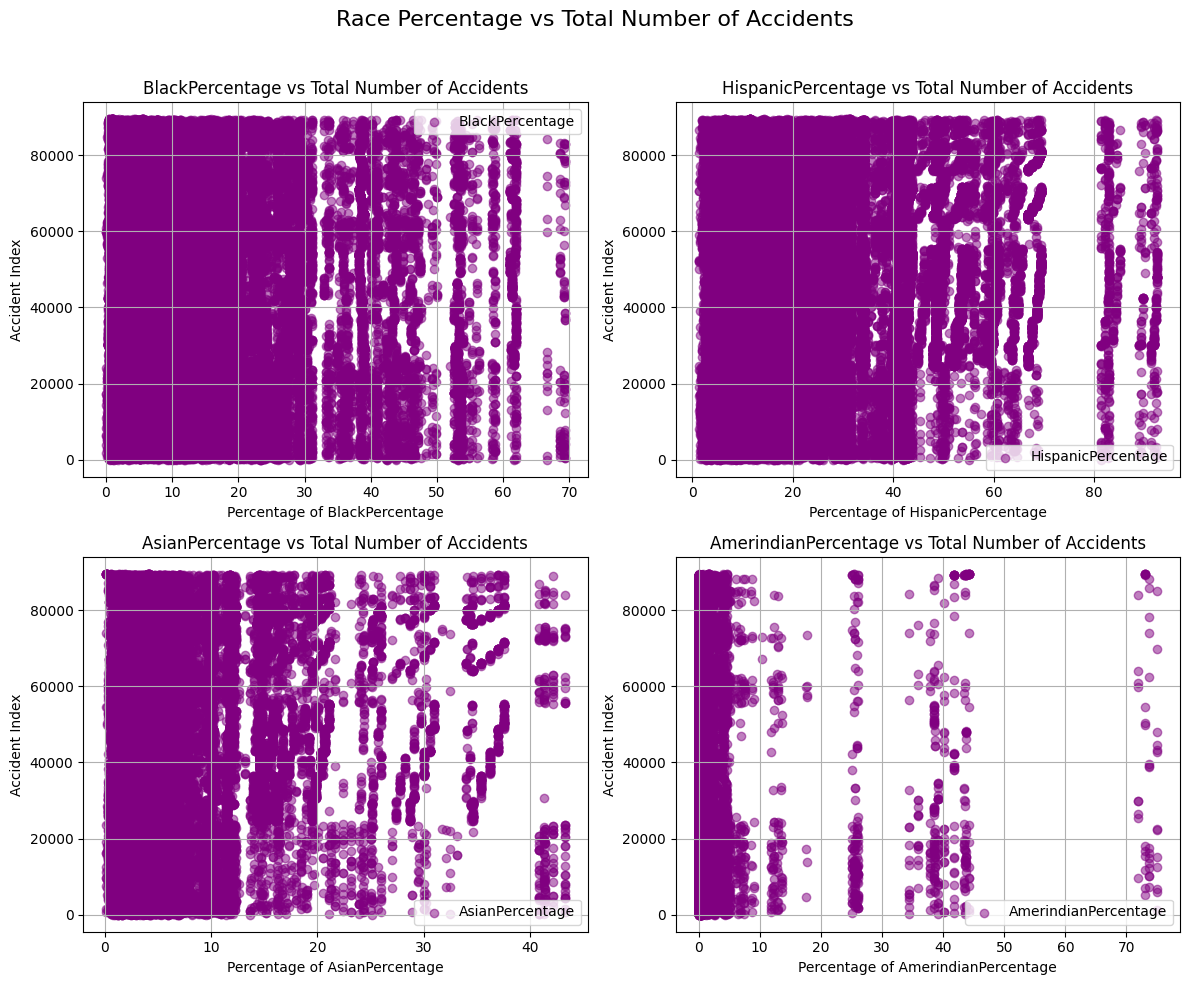

In [ ]:
# Create a grid layout for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Race Percentage vs Total Number of Accidents', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Define race columns
race_columns = ['BlackPercentage', 'HispanicPercentage', 'AsianPercentage', 'AmerindianPercentage']

# Plot each race percentage on a separate subplot
for i, race_column in enumerate(race_columns):
    axes[i].scatter(df_filtered[race_column], range(len(df_filtered)), label=race_column, color='purple', alpha=0.5)
    axes[i].set_title(f'{race_column} vs Total Number of Accidents')
    axes[i].set_xlabel(f'Percentage of {race_column}')
    axes[i].set_ylabel('Accident Index')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the title
plt.show()

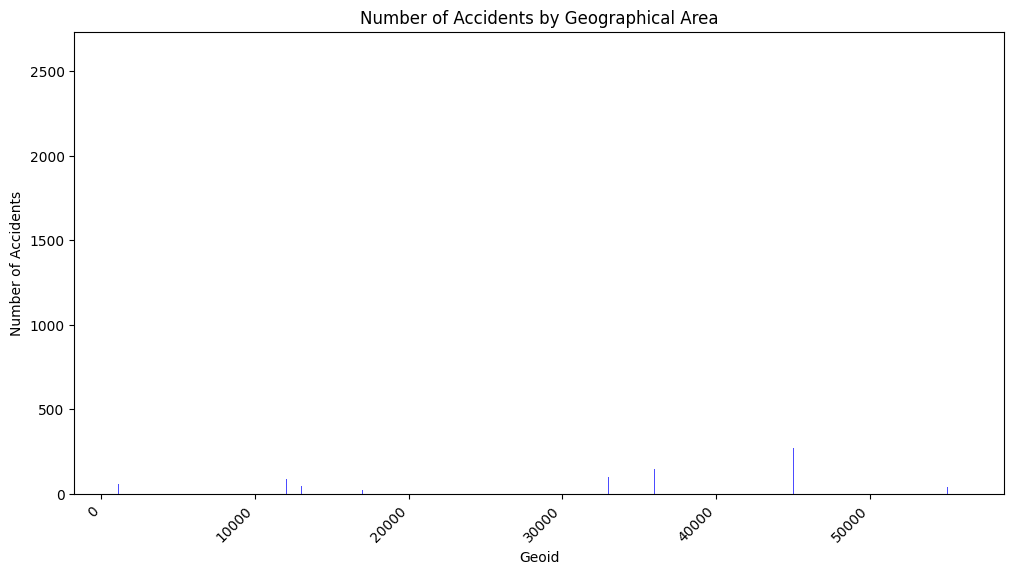

In [ ]:
# Group by 'geoid' and count the number of accidents in each geographical area
accidents_by_geoid = df_filtered.groupby('geoid')['number_of_fatalities'].count().reset_index()

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(accidents_by_geoid['geoid'], accidents_by_geoid['number_of_fatalities'], color='blue', alpha=0.7)
plt.title('Number of Accidents by Geographical Area')
plt.xlabel('Geoid')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
distinct_geoIDs_count = df_filtered['geoid'].nunique()

print(f"Distinct Number of geoIDs: {distinct_geoIDs_count}")

Distinct Number of geoIDs: 831


In [ ]:
!pip install pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.0 MB/s eta 0:00:00


In [ ]:
import pydeck as pdk

# Replace 'YOUR_MAPBOX_TOKEN' with your actual Mapbox API token
MAPBOX_TOKEN = 'pk.eyJ1IjoibXdpbmNoZXN0ZXIyIiwiYSI6ImNscHVteDVwbTBsZjgya282MDd6c2h4OGUifQ.u0fN0xvUZT00t0_yO92fRQ'

# Sample data (replace this with your data)
data = [
    {'latitude': 37.7749, 'longitude': -122.4194, 'weight': 10},
    {'latitude': 40.7128, 'longitude': -74.0060, 'weight': 5},
    # Add more data points as needed
]

# Create a PyDeck layer for the heatmap
heatmap_layer = pdk.Layer(
    'HeatmapLayer',
    data,
    get_position='[longitude, latitude]',
    get_weight='weight',
)

# Set the initial view state for the map
view_state = pdk.ViewState(
    latitude=37.7749,
    longitude=-122.4194,
    zoom=3,
    pitch=0,
)

# Create a PyDeck deck
deck = pdk.Deck(
    layers=[heatmap_layer],
    initial_view_state=view_state,
    map_style='mapbox://styles/mapbox/dark-v10'
)

# Use the to_html() method to get the HTML code
html_code = deck.to_html()

# Display the HTML code in Colab
from IPython.core.display import HTML

HTML(html_code)


<IPython.core.display.Javascript object>

<IPython.core.display.HTML object>